In [2]:
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma

### Multi-armed Bandit Problem

In [3]:
np.random.seed(31)
random.seed(31)


n_impressions = 10000
n_users = 100
n_items = 3

class User:
    def __init__(self, index):
        self.index = index
        self.interest_mean = np.random.randint(1, 10, n_items)
        
    def interest(self, index):
        return np.random.normal(self.interest_mean[index], 1)
        
        
class Item:
    def __init__(self, index):
        self.index = index
        self.score = np.random.randint(1, 10)
        
        
class Algorithm:
    
    def choose(self, user, items):
        raise NotImplemented

    def update(self, user, item):
        raise NotImplemented


def evaluate(algo, smooth=0.998):
    total_reward = 0
    smooth_reward_list = []
    prev_smooth_reward = 0
    for i in range(n_impressions):
        user = random.choice(users)
        item = algo.choose(user, items)
        reward = user.interest(item.index) * item.score
        algo.update(user, item, reward)

        # smooth reward for visualization
        smooth_reward = smooth * prev_smooth_reward + (1 - smooth) * reward  # exponential weighted average
        prev_smooth_reward = smooth_reward
        smooth_reward = smooth_reward / (1 - smooth ** (i + 1))  # bias correction
        smooth_reward_list.append(smooth_reward)
        
        total_reward += reward
    return smooth_reward_list, total_reward

users = [User(i) for i in range(n_users)]
items = [Item(i) for i in range(n_items)]

## EpsilonGreedy

0 99505.13726516165
0.12 136919.04993355696
0.36 144550.8395051176
0.48 141006.490709605
0.72 134545.88208135802
1 126318.3898281149


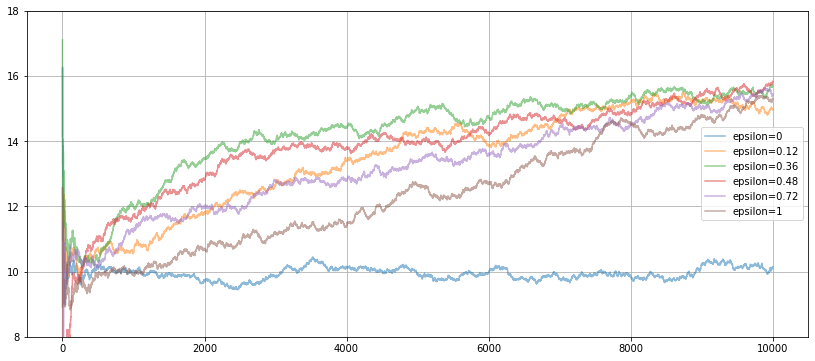

In [7]:
class EpsilonGreedy(Algorithm):
    
    def __init__(self, epsilon=0.1):
        self.init_epsilon = epsilon
        self.epsilon = epsilon
        
        self.values = defaultdict(lambda : defaultdict(int))
        self.counts = defaultdict(lambda : defaultdict(int))
        self.step = 0
    
    def choose(self, user, items):
        if np.random.uniform() < self.epsilon:
            item = random.choice(items)
        else:
            best_value = -float("inf")
            best_item = None
            for i in range(len(items)):
                value = self.values[user.index][i] / (self.counts[user.index][i] + 1e-4)
                if value > best_value:
                    best_value = value
                    best_item = items[i]
            item = best_item
        self.step += 1
        return item
    
    def update(self, user, item, reward):
        self.counts[user.index][item.index] += 1
        self.values[user.index][item.index] += reward
        self.epsilon -= (self.init_epsilon / n_impressions)
        
        
plt.figure(figsize=(14, 6))
for epsilon in [0, 0.12, 0.36, 0.48, 0.72, 1]:
    reward_list, info = evaluate(EpsilonGreedy(epsilon))
    plt.plot(reward_list, label=f"epsilon={epsilon}", alpha=0.5)
    print(epsilon, info)
plt.grid()
plt.ylim((8, 18))
plt.legend()
plt.show()

## Thompson Sampling

0.5 112096.166965321
1.0 125968.79871415302
2.0 139499.62978136542
3.0 146234.4897821855
5 129465.1687112534


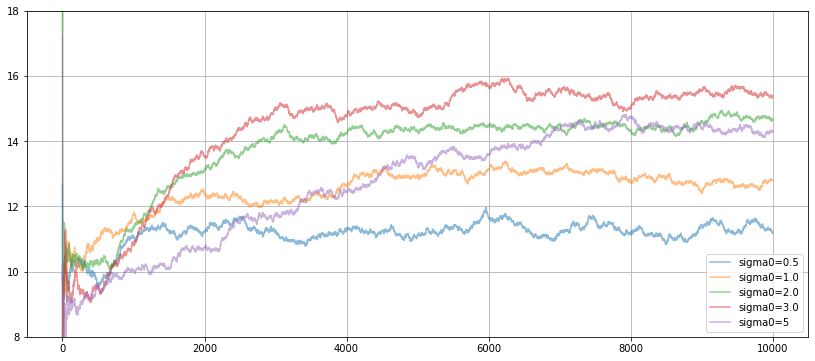

In [8]:
class ThompsonSample(Algorithm):
    """Gaussian Thompson Sampling"""
    
    def __init__(self, sigma0):
        self.params = defaultdict(lambda : defaultdict(lambda : [0, 1e12]))
        self.counts = defaultdict(lambda : defaultdict(int))
        self.values = defaultdict(lambda : defaultdict(int))
        self.sigma0 = sigma0
    
    def choose(self, user, items):
        best_sample = -float("inf")
        best_item = None
        for item in items:
            mu, sigma = self.params[user.index][item.index]
            sample = np.random.normal(mu, sigma)
            if sample > best_sample:
                best_sample = sample
                best_item = item
        return best_item
    
    def update(self, user, item, reward):
        sigma0 = self.sigma0  # known std of the likelihood
        
        R = self.values[user.index][item.index]
        n = self.counts[user.index][item.index]
        mu, sigma = self.params[user.index][item.index]
        mu = (mu / sigma0 ** 2 + R / sigma ** 2) / (1 / sigma0 ** 2 + (n + 1) / sigma ** 2)
        sigma = 1 / (1 / sigma0 ** 2 + (n + 1) / sigma ** 2)
        sigma = (sigma ** 2 + sigma0 ** 2) ** 0.5
        
        self.values[user.index][item.index] += reward
        self.counts[user.index][item.index] += 1
        self.params[user.index][item.index] = [mu, sigma]
        
plt.figure(figsize=(14, 6))
for sigma0 in [0.5, 1.0, 2.0, 3.0, 5]:
    reward_list, info = evaluate(ThompsonSample(sigma0))
    plt.plot(reward_list, label=f"sigma0={sigma0}", alpha=0.5)
    print(sigma0, info)
plt.grid()
plt.ylim((8, 18))
plt.legend()
plt.show()

### UCB

3 139466.98685993272
6 151515.12279028076
9 153169.0582071808
12 148466.19269076455
15 144678.08530776203


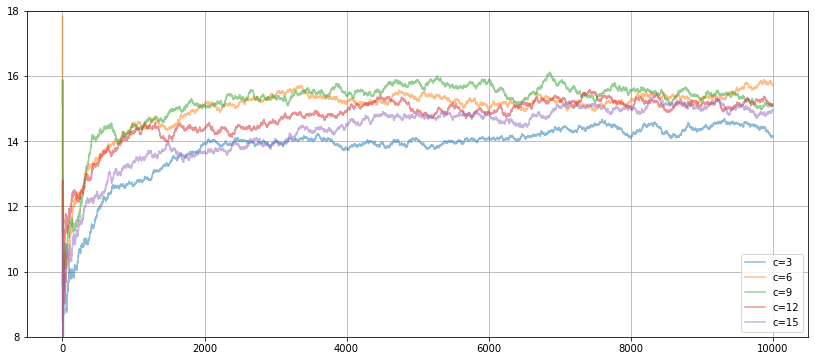

In [10]:
class UCB(Algorithm):
    
    def __init__(self, c=2.0):
        self.counts = defaultdict(lambda : defaultdict(int))
        self.values = defaultdict(lambda : defaultdict(int))
        self.c = c
        self.step = 0
    
    def choose(self, user, items):
        best_score = -float("inf")
        best_item = None
        for item in items:
            R = self.values[user.index][item.index]
            k = self.counts[user.index][item.index]
            score = R / (k + 1) + self.c * (np.log(self.step + 1) / (k + 1)) ** 0.5
            if score > best_score:
                best_score = score
                best_item = item
        self.step += 1
        return best_item
    
    def update(self, user, item, reward):
        self.values[user.index][item.index] += reward
        self.counts[user.index][item.index] += 1
        
plt.figure(figsize=(14, 6))
for c in [3, 6, 9, 12, 15]:
    reward_list, info = evaluate(UCB(c))
    plt.plot(reward_list, label=f"c={c}", alpha=0.5)
    print(c, info)
plt.grid()
plt.ylim((8, 18))
plt.legend()
plt.show()